In [1]:
import geopandas as gpd
import pandas as pd
import ee
import os
import gee_objects as gee
import image_manipulation as im
import matplotlib.pyplot as plt
from tqdm import tqdm

# ee.Authenticate()

ee.Initialize()

In [4]:
crs_metre = '32719'
crs_degree = '4326'

## Data retrieval

In [2]:
comunas_path = os.path.join('Data', 'Comunas')
comunas = gpd.read_file(comunas_path).to_crs(crs_degree)

In [79]:
petorca = comunas[comunas['Comuna'] == 'Petorca']

In [80]:
gpd.io.file.fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

plant_path = os.path.join('Data', 'CIREN2023_petorca_paltos.kml')
plantaciones = gpd.read_file(plant_path, driver='LIBKML').to_crs(crs_degree)

In [81]:
rios_path = os.path.join('Data', 'Hidrografia')
rios = gpd.read_file(rios_path).to_crs(crs_degree).clip(petorca)

In [154]:
agua_path = os.path.join('Data', 'Masas de agua')
agua = gpd.read_file(agua_path).to_crs(crs_degree).clip(petorca)
agua = agua[agua['TIPO_MAGUA'] == 'Laguna']

In [167]:
manz_urb_path = os.path.join('Data', 'R05', 'MANZANA_IND_C17.shp')
manz_rur_path = os.path.join('Data', 'R05', 'MANZANA_ALDEA_C17.shp')

manz_urb = gpd.read_file(manz_urb_path).to_crs(crs_degree).clip(petorca)
manz_rur = gpd.read_file(manz_rur_path).to_crs(crs_degree).clip(petorca)

manzanas = pd.concat([manz_urb, manz_rur], ignore_index=True).reset_index(drop=True)

### Save data

In [170]:
petorca.to_file(os.path.join('Data', 'petorca.json'), driver="GeoJSON")
plantaciones.to_file(os.path.join('Data', 'plantaciones.json'), driver="GeoJSON")
rios.to_file(os.path.join('Data', 'rios.json'), driver="GeoJSON")
agua.to_file(os.path.join('Data', 'agua.json'), driver="GeoJSON")
manzanas.to_file(os.path.join('Data', 'manz.json'), driver="GeoJSON")

## Load data

In [42]:
petorca = gpd.read_file(os.path.join('Data', 'petorca.json'))
plantaciones = gpd.read_file(os.path.join('Data', 'plantaciones.json'))
rios = gpd.read_file(os.path.join('Data', 'rios.json'))
agua = gpd.read_file(os.path.join('Data', 'agua.json'))
manzanas = gpd.read_file(os.path.join('Data', 'manz.json'))


## Plot raw data

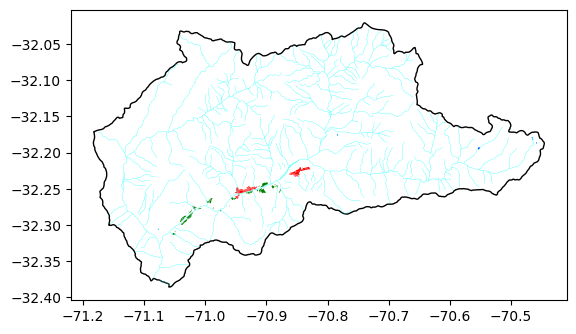

In [157]:
fig, ax = plt.subplots()

petorca.boundary.plot(ax=ax, color='black', linewidth=1)
plantaciones.plot(ax=ax, color='green')
rios.plot(ax=ax, color='cyan', linewidth=0.2)
agua.plot(ax=ax, color='blue')
manzanas.plot(ax=ax, color='red')

plt.show()

## Testing

### Image retrieval

In [85]:
name = 'Petorca'
geo = petorca.geometry

satt = 'Landsat-8'
dates = ('2015-01-01', '2023-12-31')
day_freq = 30

region = gee.GEERegion(geo, name, crs_degree)

images = region.get_images(*dates, dayfreq=day_freq, satt=satt)

indexes = ['NDVI', 'NDWI', 'NMDI', 'NDDI']
indexes = {index: region.get_indexes(index, images, add_bands=True) for index in indexes}

### Make the grid

In [44]:
pix_res = 10  # meters
geom = geo.geometry
dim_small = 15
dim_large = 60

grid_small = im.make_geo_grid(geom, dim_small, pix_res)
grid_large = im.make_geo_grid(geom, dim_large, pix_res)

#### Grid plotting

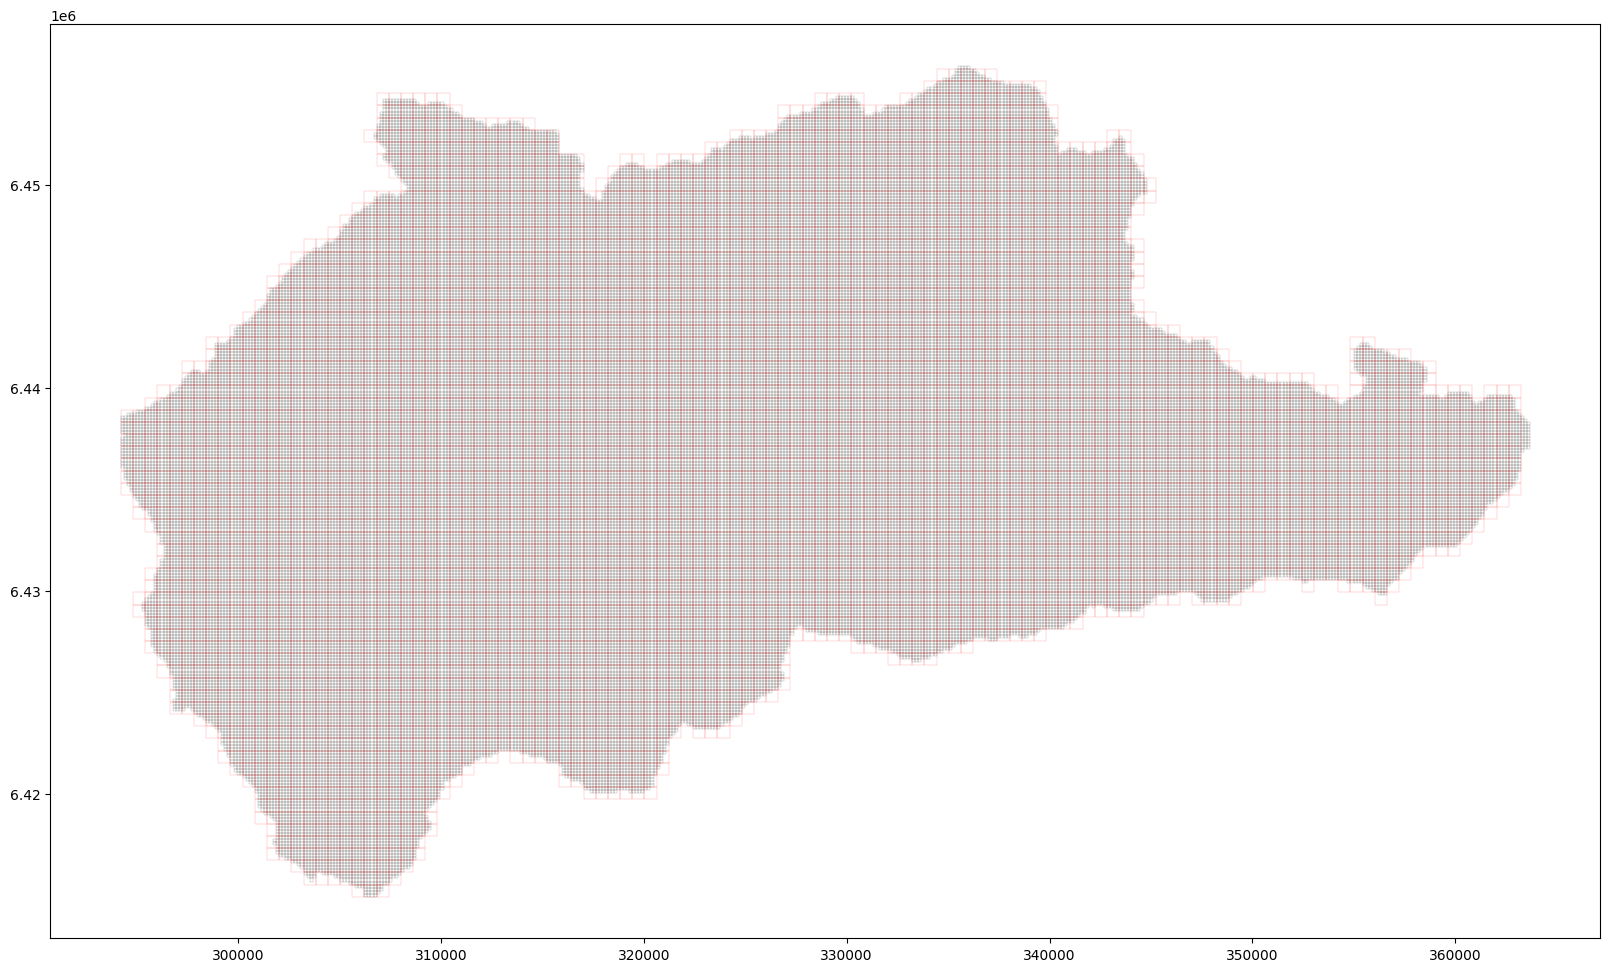

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))
grid_small.boundary.plot(ax=ax, edgecolor='black', linewidth=0.1)
grid_large.boundary.plot(ax=ax, edgecolor='red', linewidth=0.1)

plt.show()

### Grid intersection

In [46]:
# Urban areas
geo_manz = manzanas.to_crs(crs_metre).unary_union
grid_urban = grid_small[grid_small.intersects(geo_manz)]

# Plantations
geo_plant = plantaciones.to_crs(crs_metre).unary_union
grid_plant = grid_small[grid_small.intersects(geo_plant)]

# Water bodies
geo_agua = agua.to_crs(crs_metre).unary_union
grid_agua = grid_small[grid_small.intersects(geo_agua)]

# Rivers
geo_rios = rios.to_crs(crs_metre).unary_union
grid_rios = grid_small[grid_small.intersects(geo_rios)]


# Make classes exclusive

# Rios and agua are exclusive
grid_rios = grid_rios[~grid_rios.within(grid_agua.unary_union)]

# Plantaciones and rios are exclusive
grid_plant = grid_plant[~grid_plant.within(grid_rios.unary_union)]

# Urban and plantaciones are exclusive and urban and rios are exclusive
grid_urban = grid_urban[~grid_urban.within(grid_plant.unary_union)]
grid_urban = grid_urban[~grid_urban.within(grid_rios.unary_union)]


In [47]:
# Not classified zones

# Union of all classified zone grids
grid_class = pd.concat([grid_urban, grid_plant, grid_agua, grid_rios], ignore_index=True).reset_index(drop=True)

grid_others_large = grid_large[~grid_large.intersects(grid_class.unary_union)]
not_grid_others_large = grid_large[grid_large.intersects(grid_class.unary_union)]

grid_others_small = grid_small[grid_small.within(not_grid_others_large.unary_union)]
grid_others_small = grid_others_small[~grid_others_small.within(grid_class.unary_union)]

grid_others = pd.concat([grid_others_small, grid_others_large], ignore_index=True).reset_index(drop=True)

In [145]:
# Proof that classified and others are exclusive

grid_class[grid_class.within(grid_others.unary_union)]

,geometry


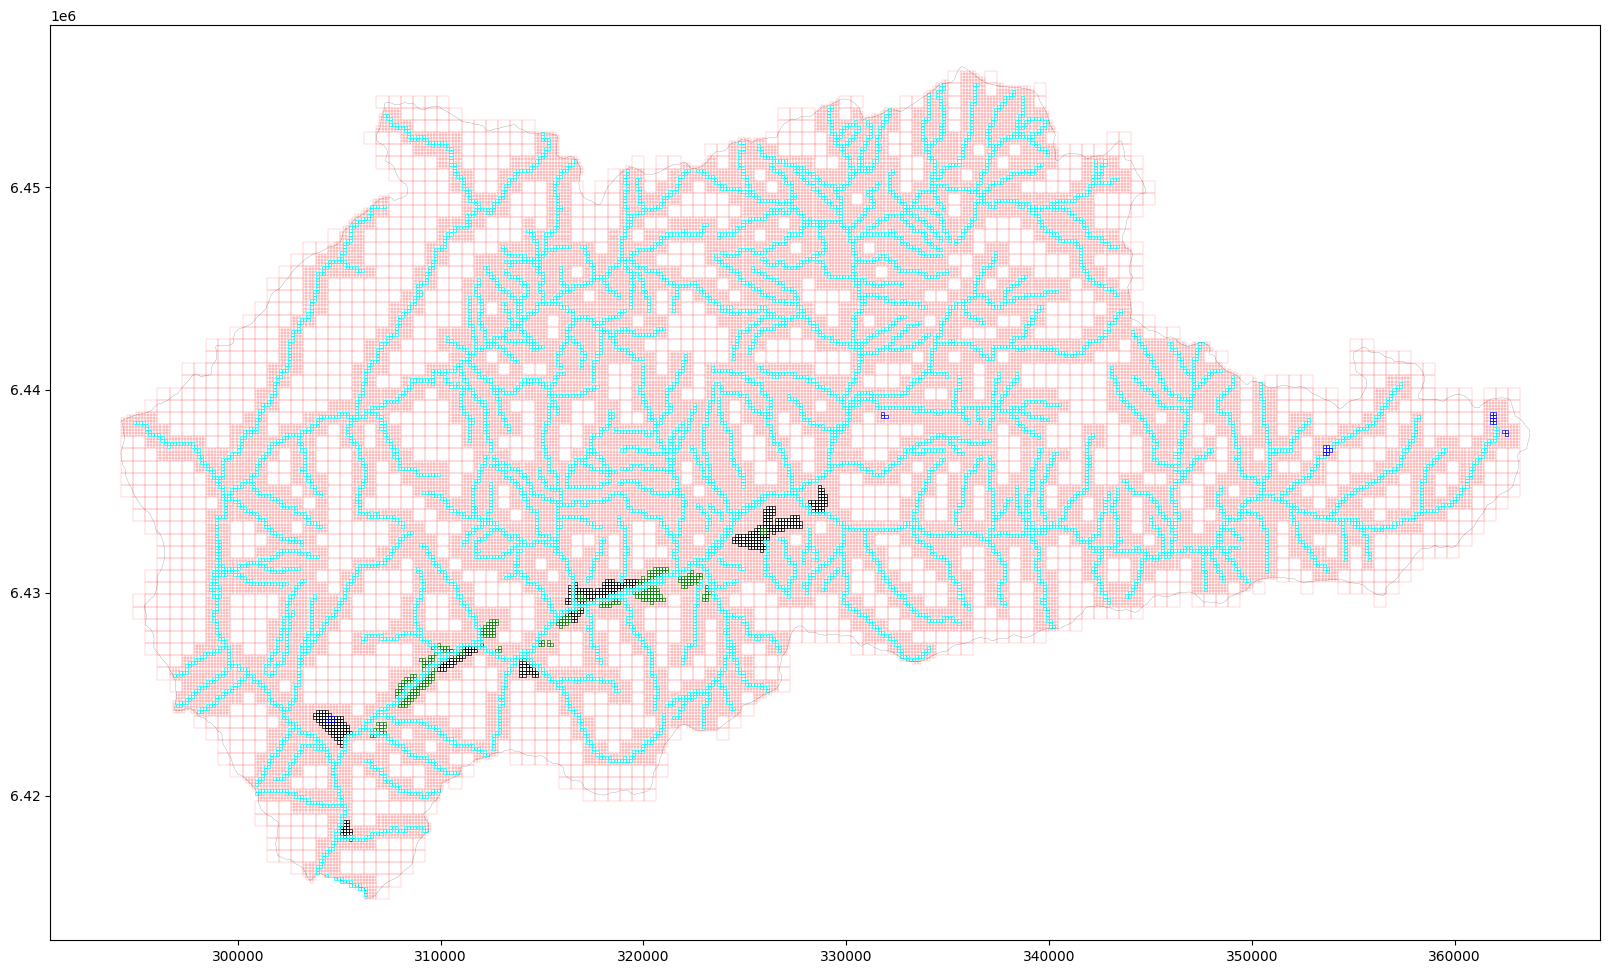

In [48]:
fig, ax = plt.subplots(figsize=(20, 20))

grid_others.boundary.plot(ax=ax, edgecolor='red', linewidth=0.1)
grid_urban.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
grid_plant.boundary.plot(ax=ax, edgecolor='green', linewidth=0.5)
grid_rios.boundary.plot(ax=ax, edgecolor='cyan', linewidth=0.5)
grid_agua.boundary.plot(ax=ax, edgecolor='blue', linewidth=0.5)

petorca.to_crs(crs_metre).boundary.plot(ax=ax, edgecolor='black', linewidth=0.1)

plt.show()

#### Save grids

In [49]:
grid_urban.to_file(os.path.join('Data', 'grids', 'grid_urban.json'), driver="GeoJSON")
grid_plant.to_file(os.path.join('Data', 'grids', 'grid_plant.json'), driver="GeoJSON")
grid_agua.to_file(os.path.join('Data', 'grids', 'grid_agua.json'), driver="GeoJSON")
grid_rios.to_file(os.path.join('Data', 'grids', 'grid_rios.json'), driver="GeoJSON")
grid_others.to_file(os.path.join('Data', 'grids', 'grid_others.json'), driver="GeoJSON")

### Image splitting

#### Load grids

In [50]:
# Load grids
grid_urban = gpd.read_file(os.path.join('Data', 'grids', 'grid_urban.json'))
grid_plant = gpd.read_file(os.path.join('Data', 'grids', 'grid_plant.json'))
grid_agua = gpd.read_file(os.path.join('Data', 'grids', 'grid_agua.json'))
grid_rios = gpd.read_file(os.path.join('Data', 'grids', 'grid_rios.json'))
grid_others = gpd.read_file(os.path.join('Data', 'grids', 'grid_others.json'))

#### Image splitting for classification

In [83]:
image_test = images[10]

grids = {
    'urban': grid_urban,
    'plant': grid_plant,
    'agua': grid_agua,
    'rios': grid_rios,
    'otros': grid_others
}

splitted_image = {
     'geometry': [],
     'images': [],
     'class': []
}

for key, grid in grids.items():
    splitted_image['images'] += im.image_splitter(image_test, grid)
    splitted_image['geometry'] += list(grid.geometry)
    splitted_image['class'] += [key] * len(grid)

splitted_image = gpd.GeoDataFrame(splitted_image, geometry='geometry', crs=crs_metre)

#### Image splitting for time series

In [97]:
grid = grid_others.to_crs(crs_degree).geometry.unary_union

multipoly = im.make_ee_multi_polygon(grid)

image_test = images[0].clip(multipoly)

im.get_index_median(image_test, 'NDVI', scale=30)

0.18359226670354986

In [ ]:
##### OJO: ESTO TARDA MUCHO #####

geometries = {key: im.make_ee_multi_polygon(grid.to_crs(crs_degree).geometry.unary_union) 
              for key, grid in tqdm(grids.items(), desc='Making geometries')}

columns = ['date', 'NDVI', 'NDWI', 'NMDI']

time_series = {
    key: {column: [] for column in columns}
    for key in grids.keys()
}

for img in tqdm(images, desc='Iterating over images'):
    for key, geo in geometries.items():
        time_series[key]['date'].append(img.date)

        img_clip = img.clip(geo)
        for index in columns[1:]:
            val = im.get_index_median(img_clip, index, scale=30)
            time_series[key][index].append(val)

for key, ts in time_series.items():
    ts = pd.DataFrame(ts)
    ts.to_excel(os.path.join('Data', f'{name}_{key}_time_series.xlsx'))
    print(f'{key} saved')

In [113]:
urb = pd.read_excel(os.path.join('Data', 'Petorca_urban_time_series.xlsx')).dropna()
plant = pd.read_excel(os.path.join('Data', 'Petorca_plant_time_series.xlsx')).dropna()
agua = pd.read_excel(os.path.join('Data', 'Petorca_agua_time_series.xlsx')).dropna()
rios = pd.read_excel(os.path.join('Data', 'Petorca_rios_time_series.xlsx')).dropna()
otros = pd.read_excel(os.path.join('Data', 'Petorca_otros_time_series.xlsx')).dropna()

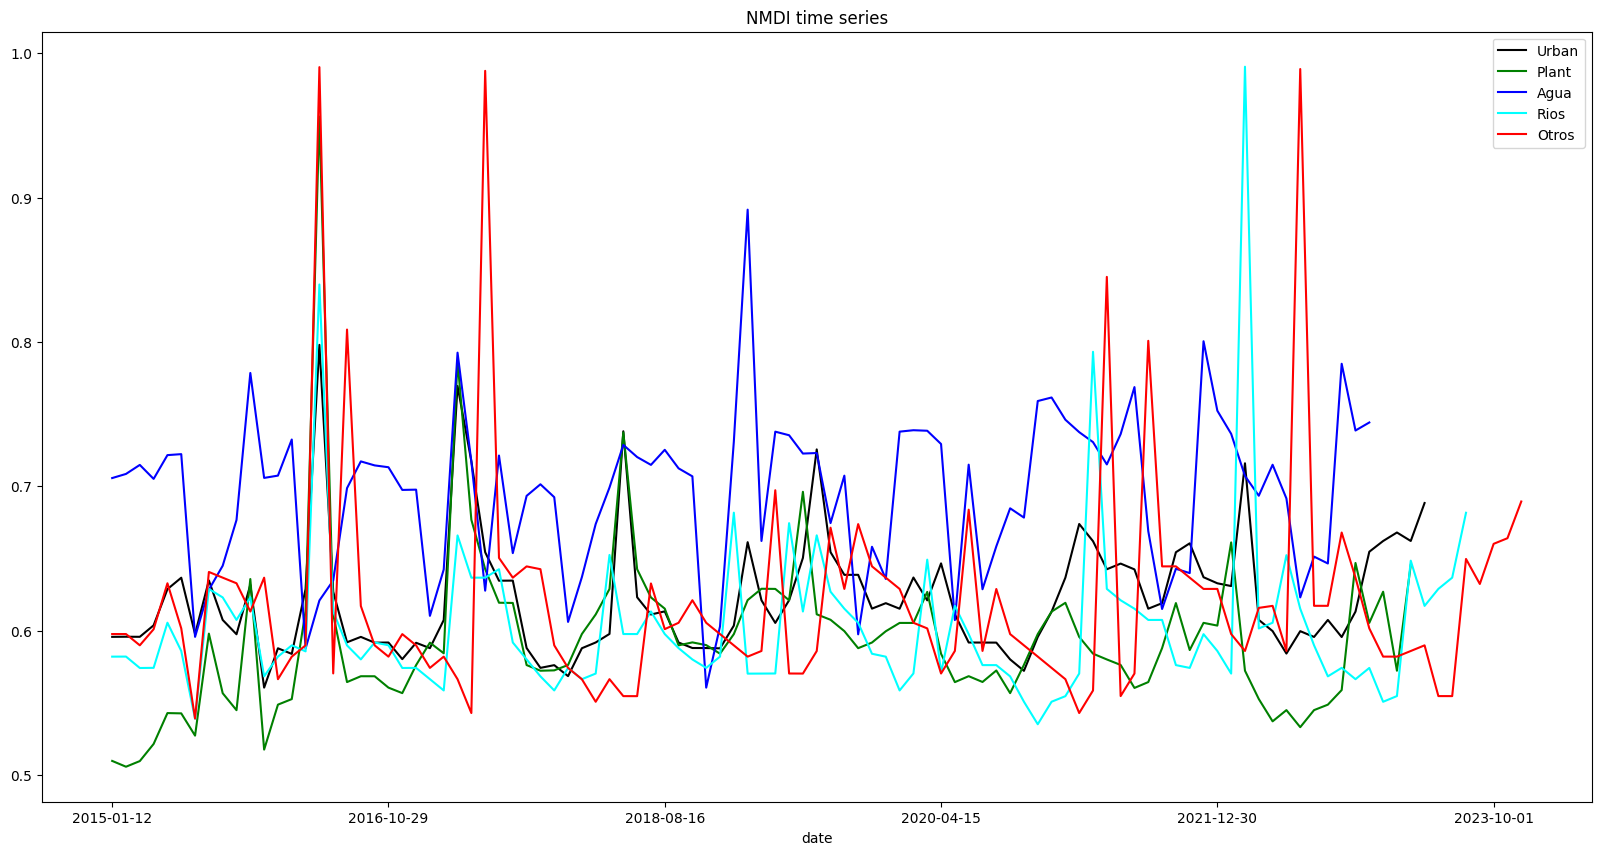

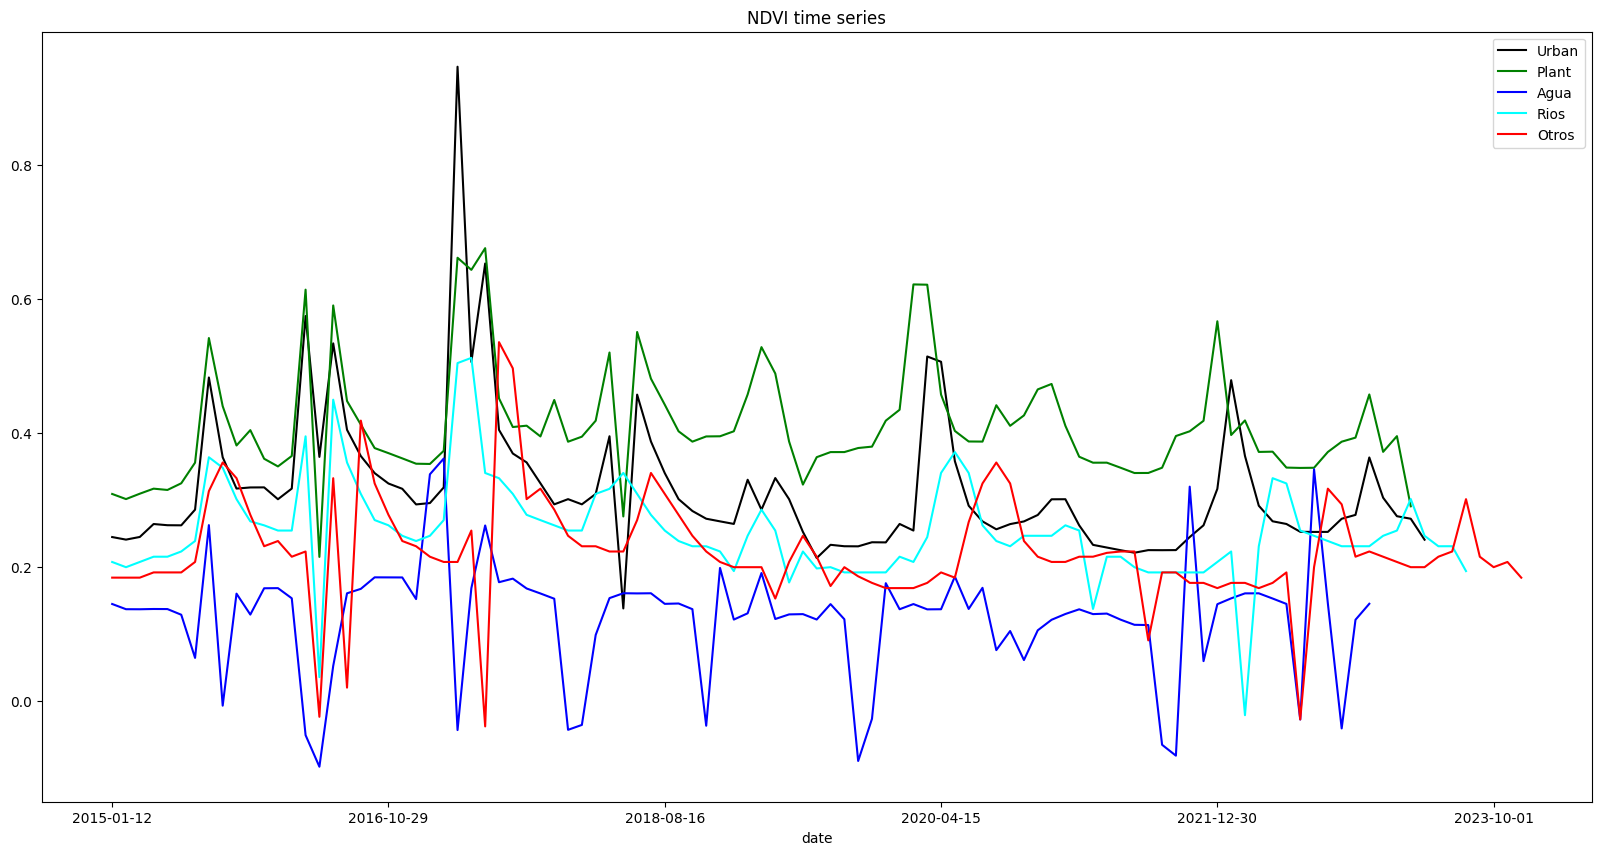

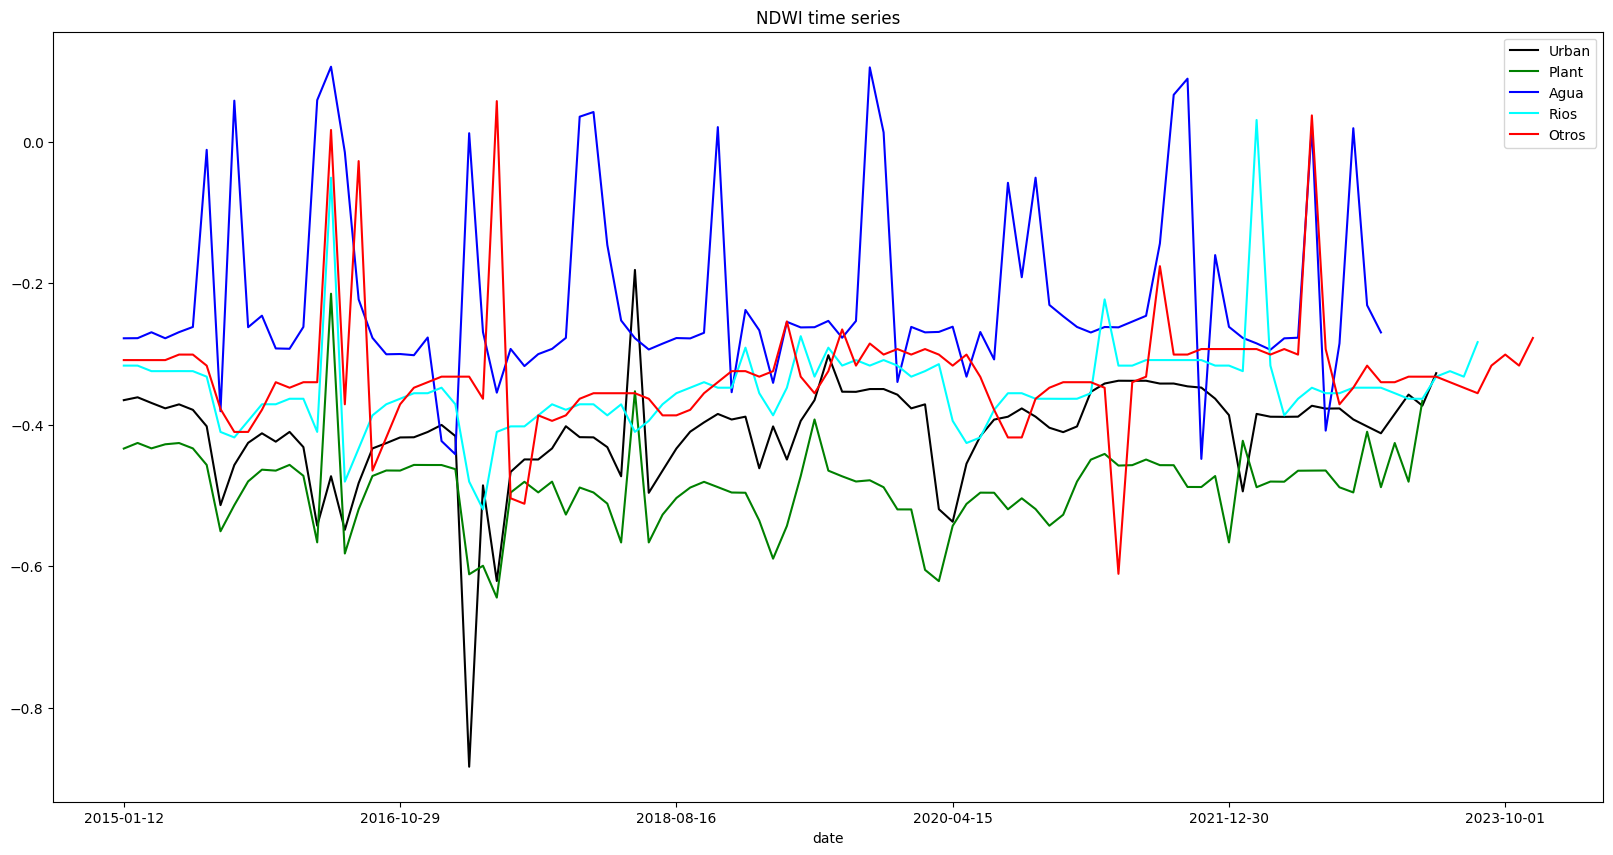

In [114]:
# Plot time series for indexes

index = ['NMDI', 'NDVI', 'NDWI']

for index in index:

    fig, ax = plt.subplots(figsize=(20, 10))

    urb.plot(x='date', y=index, ax=ax, label='Urban', color='black')
    plant.plot(x='date', y=index, ax=ax, label='Plant', color='green')
    agua.plot(x='date', y=index, ax=ax, label='Agua', color='blue')
    rios.plot(x='date', y=index, ax=ax, label='Rios', color='cyan')
    otros.plot(x='date', y=index, ax=ax, label='Otros', color='red')

    ax.set_title(f'{index} time series')

    plt.show()
